In [79]:
import io
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon

In [88]:
file_path = "/Users/lune/ISP/rolling-in-the-deep/experiments/2025-W3-01-13/results/EfficientNet_b0.pkl"

# >from CPU
#with open(file_path, "rb") as file:
#    data = pickle.load(file)


# >from GPU
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


with open(file_path, 'rb') as df:
     data = CPU_Unpickler(df).load()

print(data)

{'folds': [{'fold': 0, 'epochs': [{'epoch': 0, 'training': {'loss': tensor(0.0023, requires_grad=True), 'accuracy': 0.9427222222222222, 'precision': 0.717364403662858, 'recall': 0.9152035246767577, 'f1': 0.7498059161655486, 'auc_ovr': 0.9879006663711367, 'auc_ovo': 0.9844925767612339, 'mcc': 0.889911968728781}, 'validation': {'loss': tensor(0.0401), 'accuracy': 0.9765, 'precision': 0.801875948913035, 'recall': 0.9521950767233786, 'f1': 0.8491345945439862, 'auc_ovr': 0.9949322278694352, 'auc_ovo': 0.9931779549704078, 'mcc': 0.9532745170987565}}, {'epoch': 1, 'training': {'loss': tensor(0.0155, requires_grad=True), 'accuracy': 0.9662222222222222, 'precision': 0.7563123912898546, 'recall': 0.9625052612407347, 'f1': 0.8015588769926273, 'auc_ovr': 0.9954813209807387, 'auc_ovo': 0.9938762356657973, 'mcc': 0.9344661897240323}, 'validation': {'loss': tensor(0.2435), 'accuracy': 0.9105, 'precision': 0.6962313120311157, 'recall': 0.930592771158809, 'f1': 0.6989657243504572, 'auc_ovr': 0.97871467

/var/folders/54/7vzdgfgj2h553mb_db09hz900000gn/T/ipykernel_69594/3708514385.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), m

# metrics across epochs

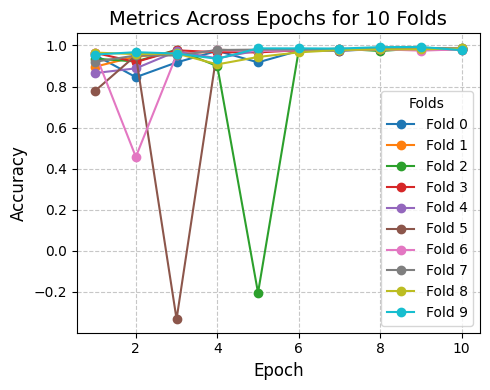

In [75]:
plt.figure(figsize=(5, 4))

for fold in data['folds']:
    fold_number = fold['fold']
    epochs = [i['epoch']+1 for i in fold['epochs']]
    metrics = [i['validation']['mcc'] for i in fold['epochs']]
    plt.plot(epochs, metrics, marker='o', label=f'Fold {fold_number}')

plt.title('Metrics Across Epochs for 10 Folds', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Folds", loc='lower right', fontsize=10)
plt.tight_layout()

plt.show()

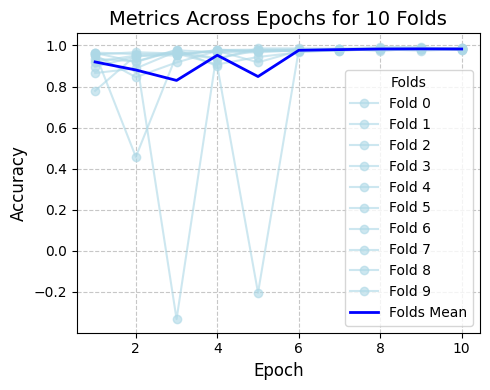

In [74]:
plt.figure(figsize=(5, 4))

metrics_to_save = []

for fold in data['folds']:
    fold_number = fold['fold']
    epochs = [i['epoch']+1 for i in fold['epochs']]
    metrics = [i['validation']['mcc'] for i in fold['epochs']]
    metrics_to_save.append(metrics)
    plt.plot(epochs, metrics, color='lightblue', alpha=0.6, marker='o', label=f'Fold {fold_number}')

metrics_to_save = np.array(metrics_to_save)
mean_metric = np.mean(metrics_to_save, axis=0)
plt.plot(epochs, mean_metric, color='blue', linewidth=2, label='Folds Mean')


plt.title('Metrics Across Epochs for 10 Folds', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Folds", loc='lower right', fontsize=10)
plt.tight_layout()

plt.show()

# metrics comparison

In [91]:
# remove 0.02
metrics1 = [fold['epochs'][-1]['validation']['accuracy'] for fold in data['folds']]
metrics2 = [fold['epochs'][-1]['validation']['accuracy']-0.02 for fold in data['folds']]

In [92]:
stat, p = wilcoxon(metrics1, metrics2)

print(f"Test Statistic: {stat}")
print(f"P-value: {p}")

Test Statistic: 0.0
P-value: 0.001953125


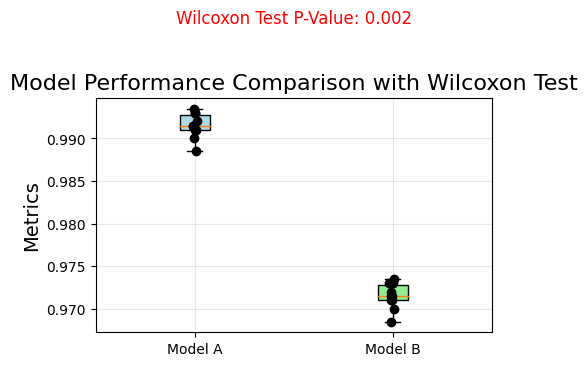

In [98]:
plt.figure(figsize=(5, 4))

metrics_list = [metrics1, metrics2]
labels = ['Model A', 'Model B']

box = plt.boxplot(metrics_list, labels=labels, patch_artist=True, showmeans=True)

colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

jitter = 0.01  # Small random noise to spread points
for i, metrics in enumerate(metrics_list):
    x = np.random.normal(i + 1, jitter, size=len(metrics))  # Jittered x positions
    plt.scatter(x, metrics, color='black', alpha=1, zorder=3, label='Fold Performance' if i == 0 else None)

y_max = max(max(metrics1), max(metrics2)) + 0.01
plt.text(1.5, y_max, f'Wilcoxon Test P-Value: {p:.3f}', fontsize=12, ha='center', color='red')
plt.ylabel('Metrics', fontsize=14)
plt.title('Model Performance Comparison with Wilcoxon Test', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
